# Vectorizing Persistence Diagrams

In this notebook, we'll analyze a synthetic dataset and a real dataset using vectorized TDA signatures. Specifically, we'll turn persistence diagrams into persistence images and use these as features in a standard machine learning pipeline. 

In [2]:
# Import standard packages for linear algebra and statistics
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import a package to time computations
import time

# Import specialized TDA packages
from ripser import Rips
from persim import PersImage

# Package for including a figure in the notebook
from IPython.display import Image

## Part 1: Synthetic Dataset

This is an expanded version of the demonstration available at https://github.com/scikit-tda/persim. I added more parameters to the experiment and more explanation for everything.

This notebook shows how you can use persistent homology and persistence images to classify datasets.  We construct datasets from two classes, one just noise and the other noise with a big circle in the middle. We then compute persistence diagrams with [Ripser.py](https://github.com/scikit-tda/ripser.py) and convert them to persistence images with [PersIm](https://github.com/scikit-tda/persim). Using these persistence images, we build classifier using Support Vector Machines.

### Constructing the dataset

We will construct a data set consisting of several pointclouds which are just noise and several pointclouds which are noise on top of a noisy circle. The goal is to see whether tools from persistent homology can be used to classify the data into two categories. 

This is synthetic data, but one can imagine realistic tasks along these lines; e.g. https://en.wikipedia.org/wiki/Transmission_electron_cryomicroscopy.

![Cryo EM](data/Cryoem_groel.jpg)

We begin by defining a function which generates a noisy point cloud sampled from a sphere.

In [3]:
def sample_spherical(npoints, scale=1, ndim=2):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    vec = scale*np.transpose(vec)
    return vec

def noisy_sphere(npoints, scale=1, noiseLevel=0.3, offset = 0, ndim=2):
    """
    npoints = number of points sampled
    scale = radius of the sphere being sampled
    noiseLevel = how "noisy" the samples are
    offset = shifts the circle in the (1,1,...,1) direction
    """
    data = sample_spherical(npoints,scale, ndim)+scale*noiseLevel*np.random.random((npoints,ndim)) + offset*np.ones(ndim)
    return data

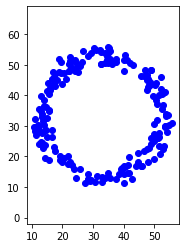

In [5]:
data = noisy_sphere(200, scale=20, offset=30)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(data[:, 0], data[:, 1], 'ob');
ax1.axis('equal');

Next we define a function which produces a noisy point cloud in space, with a given scale, in a given dimension.

In [6]:
def noise(N, scale, ndim=2):
    return scale * np.random.random((N, 2)) 

Now we construct our data set. There are lots of parameters to change to produce different experiments. In general we generate samples of random noise and samples of random noise with noisy circles embedded in them. We can change numbers of samples, how noisy everything is, size and location of the circles, etc.

In [13]:
# We first define a bunch of parameters for the experiment
total_samples = 200 # Number of samples in our experiment
samples_per_class = int(total_samples / 2) 
# Number of samples which are just noise. We will do our experiment taking an equal number each type of sample.
npoints = 400
# Number of points in each point cloud sample.
circle_noise_level = 0.4 # Noise level for the circles.
snr = 0.25
# Signal-to-noise ratio. For the images containing circles, this is the percentage of points that belong to the circle.
noise_scale = 150 # How large the noisy point cloud is
circle_scale = 30 # How large the noisy circle is. Should be chosen relative to the noise_scale.

# Generate the pure noise samples
just_noise = [noise(npoints, noise_scale) for _ in range(samples_per_class)]

# Generate the noise+circle samples
with_circle = [np.concatenate((noisy_sphere(int(snr*npoints), noiseLevel = circle_noise_level, scale=circle_scale, offset=(0.2*np.random.random()+0.4)*noise_scale), noise(npoints-int(snr*npoints), noise_scale)))
               for _ in range(samples_per_class)]

# Combine all the samples into one list.
datas = []
datas.extend(just_noise)
datas.extend(with_circle)

# Define labels. Pure noise samples are labeled with 0, noise+circles are labeled with 1.
# These labels will be used to train/test our classifyer.
labels = np.zeros(total_samples)
labels[samples_per_class:] = 1

Let's visualize the data. We'll plot a random pure noise sample and a random circle+noise sample.

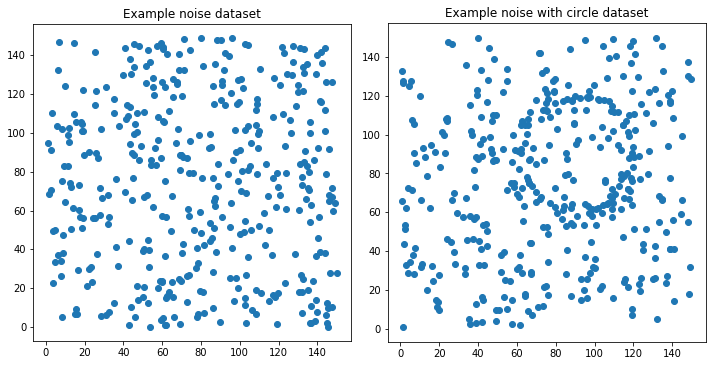

In [14]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,5)

random_sample_choice = np.random.randint(100) # Pick a number between 0 and 100.

xs, ys = just_noise[random_sample_choice][:,0], just_noise[random_sample_choice][:,1]
axs[0].scatter(xs, ys)
axs[0].set_title("Example noise dataset")
axs[0].set_aspect('equal', 'box')

xs_, ys_ = with_circle[random_sample_choice][:,0], with_circle[random_sample_choice][:,1]
axs[1].scatter(xs_, ys_)
axs[1].set_title("Example noise with circle dataset")
axs[1].set_aspect('equal', 'box')

fig.tight_layout()

### Compute persistent homology of each dataset

Generate the persistence diagram of $H_1$ for each of the datasets generated above.

In [15]:
%%time
rips = Rips(maxdim=1, coeff=2); # Apply ripser with Z_2 coefficients, up to dimension 1.
diagrams = [rips.fit_transform(data) for data in datas]
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
CPU times: user 2min 40s, sys: 12.9 s, total: 2min 53s
Wall time: 41.1 s


Let's plot persistence diagrams for a random choice of noise sample and a random choice of circle+noise. We'll use the "lifetime" plot style option because this is a step in the process of creating persistence images.

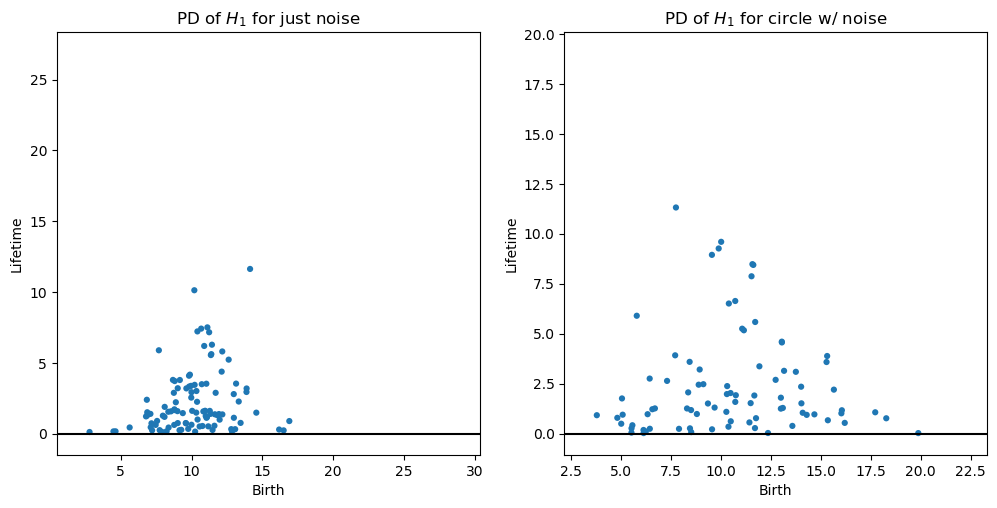

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(121)

random_sample = np.random.randint(50)

rips.plot(diagrams_h1[random_sample], show=False, legend=False, lifetime=True)
plt.title("PD of $H_1$ for just noise")

plt.subplot(122)
rips.plot(diagrams_h1[-random_sample], show=False, legend=False, lifetime=True)
plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

### Compute persistence images

We will discuss the definition of a persistence image in class. The 'persim' package is made to handle persistence images. Recall from class that we need to choose a resolution and a variance for the Gaussians. The weight function is automatically chosen to be linearly increasing in the $y$-direction.

In [19]:
%%time
pim = PersImage(pixels=(20,20), spread=1)
imgs = pim.transform(diagrams_h1)

PersImage(pixels=(20, 20), spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
CPU times: user 5.69 s, sys: 89.4 ms, total: 5.78 s
Wall time: 5.93 s


Let's take a look at the persistence images. We should interpret each image as the pixelated plot of a function $\mathbb{R}^2 \rightarrow \mathbb{R}$, with colors corresponding to height of the plot. Such a plot can be understood as a vector: by reshaping the 20-pixel-by-20-pixel image into a list of 400 numbers, we can think of it as a vector in $\mathbb{R}^{400}$.

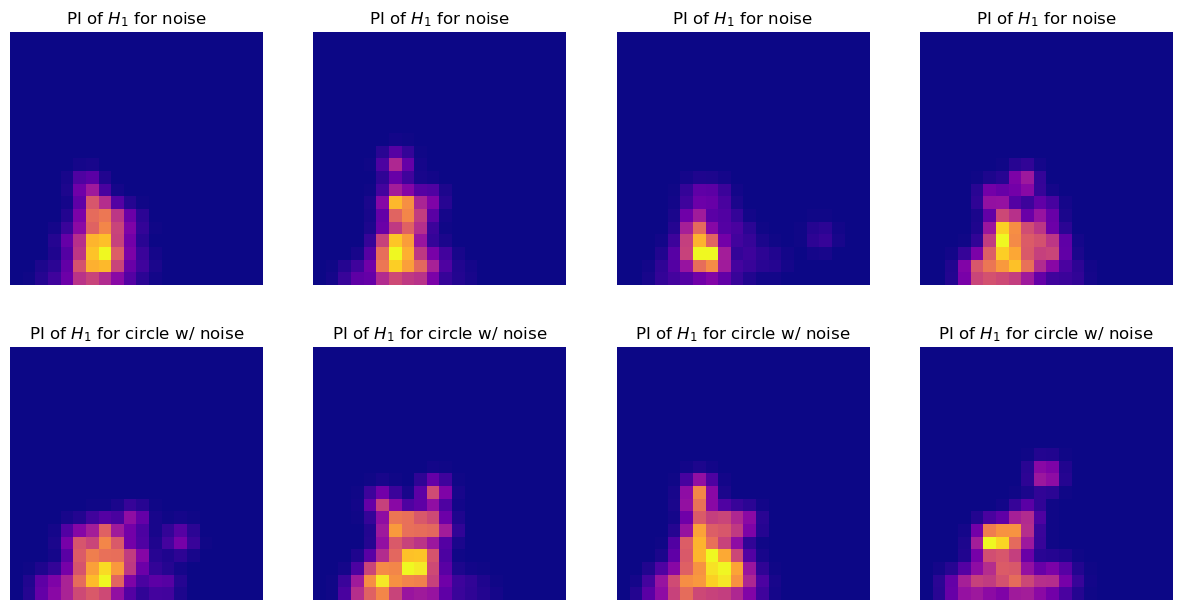

In [20]:
plt.figure(figsize=(15,7.5))

for i in range(4):
    ax = plt.subplot(240+i+1)
    pim.show(imgs[i], ax)
    plt.title("PI of $H_1$ for noise")

for i in range(4):
    ax = plt.subplot(240+i+5)
    pim.show(imgs[-(i+1)], ax)
    plt.title("PI of $H_1$ for circle w/ noise")

### Classify the datasets from the persistence images

Now we'll train a classifier on the vectorized persistence diagrams. We first flatten each persistence image so that it is really represented as a vector in $\mathbb{R}^{400}$.

In [21]:
imgs_array = np.array([img.flatten() for img in imgs])

Next we randomly divide our data into a training set and a testing set (with labels for each).

In [22]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.20)

Next, we train a Support Vector Machines classifier on the training set. Roughly, SVM looks for a $399$-dimensional affine hyperplane in $\mathbb{R}^{400}$ which best separates the two classes in the training data set. This hyperplane can then be used to guess the label of unseen data from the testing dataset.

In [23]:
modelSVM = SVC(kernel="linear") # Defines the model with optional parameters

modelSVM.fit(X_train, y_train) # Trains the model on the training data

SVC(kernel='linear')

Now we can run the trained classifier on the unseen testing data to see how well it performs.

In [24]:
modelSVM.score(X_test,y_test)

0.95

The model performs extremely well!

The hyperplane we found in the training stage is determined by a normal vector (plus a bias). This is a $400$-dimensional vector, which we can reshape back into an image to get an idea of how the classifier distinguishes the classes.

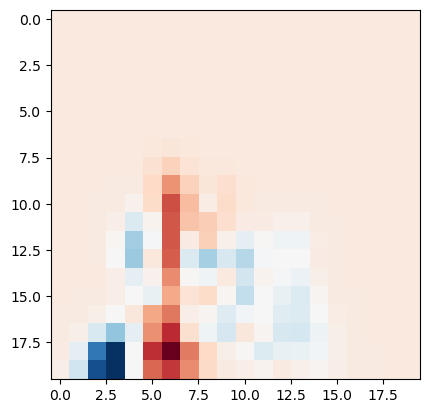

In [25]:
classifying_image = np.copy(modelSVM.coef_).reshape((20,20))
plt.imshow(classifying_image,cmap = plt.cm.RdBu)
plt.show()

### Comparing to a  Naive Baseline

To test whether this performance is a result of the efficacy of logistic regression, or the persistence image representation is actually useful, let's try to classify with a more naive approach.

Each sample in our data set is an npoints-by-2 array. We could flatten each of these to get a vector in $\mathbb{R}^{2 \cdot \mbox{npoints}}$, then run the same regression procedure to see if logistic regression can classify these vectors. 

First we flatten the data, split into training and test sets and perform regression.

In [27]:
datas_array = np.array([sample.flatten() for sample in datas])

X_train, X_test, y_train, y_test = train_test_split(datas_array, labels, test_size=0.20, random_state=42)

modelSVM = SVC(kernel="linear") # Defines the model with optional parameters
modelSVM.fit(X_train, y_train) # Trains the model on the training data

print('Naive SVM score:', modelSVM.score(X_test, y_test))

Naive SVM score: 0.575


At least the result is better than random guessing...

We can visualize the classifying vector learned by logistic regression.

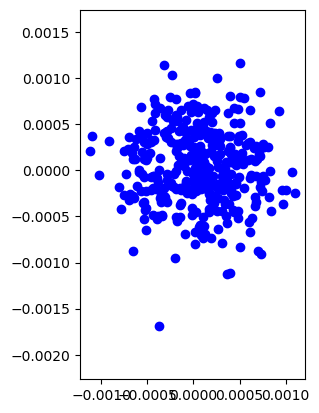

In [28]:
classifying_image = np.copy(modelSVM.coef_).reshape((400,2))

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(classifying_image[:, 0], classifying_image[:, 1],'ob')
ax1.axis('equal'); 

## Part 2: Classifying Weighted Graphs

This dataset is also simulated, but comes from a more realistic source. The data comes from a set of ~400 *districting plans* for the state of Pennsylvania---each districting plan is a partition of Pennsylvania into 18 (path connected) districts, each of which has the same population (up to a small tolerance). 

To get a persistence diagram from a districting plan:
- The districting plan is converted into an adjacency graph for the districts
- nodes are weighted by, say, Republican vote share in a given election
- each edge is assigned the maximum value of its neighboring nodes, so that we get an overall filtration of the graph (considered as a simplicial complex)
- sublevel set degree-0 persistent homology is run on the resulting filtered simplicial complex

This is illustrated in the figure below.

![title](data/districting.pdf)

Studying statistics of the space of all districting plans is an important part of treating the *gerrymandering problem*, which is the problem that districts can be drawn adversarily to favor one party over the other, regardless of the vote distribution in the state. In the paper https://arxiv.org/abs/2007.02390, we use these TDA signatures as proxies for districting plans in order to simplify statistical analyses. 

Unfortunately, the space of districting plans is extremely large and complicated. Ensembles of districting plans are generated via various Markov chain algorithms which can be used to explore the space of potential plans.

In this dataset, we have generated plans in two classes. Each class used a Markov chain which aimed to maximize the number of districts one by either Republicans or Democrats in a given election. Our task is to see if these plans can be classified by their topological signatures.

### Read in the Data

The persistence diagrams for the weighted graphs are precomputed and saved. So all we have to do is load in the persistence features from the csv files in the data folder. The data is stored in csv files with the most persistent feature for all plans stored in the first file, second most persistent feature in another file, etc. The classes are a bit unbalanced here.

In [29]:
barcodes = []

for j in range(6):
    fileName = "data/50biased_"+str(j)+".csv"
    file = np.genfromtxt(fileName,delimiter=',')
    barcodes.append(file)

Combine the various classes into barcodes for the democrat-biased plans...

In [30]:
dem_barcodes = []

for j in range(1,243):
    barcode = []
    for k in range(6):
        bar = barcodes[k][j,1:3]
        barcode.append(bar)
    dem_barcodes.append(np.array(barcode))

...and the republican-biased plans.

In [31]:
rep_barcodes = []

for j in range(243,431):
    barcode = []
    for k in range(6):
        bar = barcodes[k][j,1:3]
        barcode.append(bar)
    rep_barcodes.append(np.array(barcode))

Combine them into one big list of barcodes and record the labels.

In [32]:
all_barcodes = dem_barcodes + rep_barcodes

In [33]:
y = [0]*len(dem_barcodes)+[1]*len(rep_barcodes)

### Create persistence images

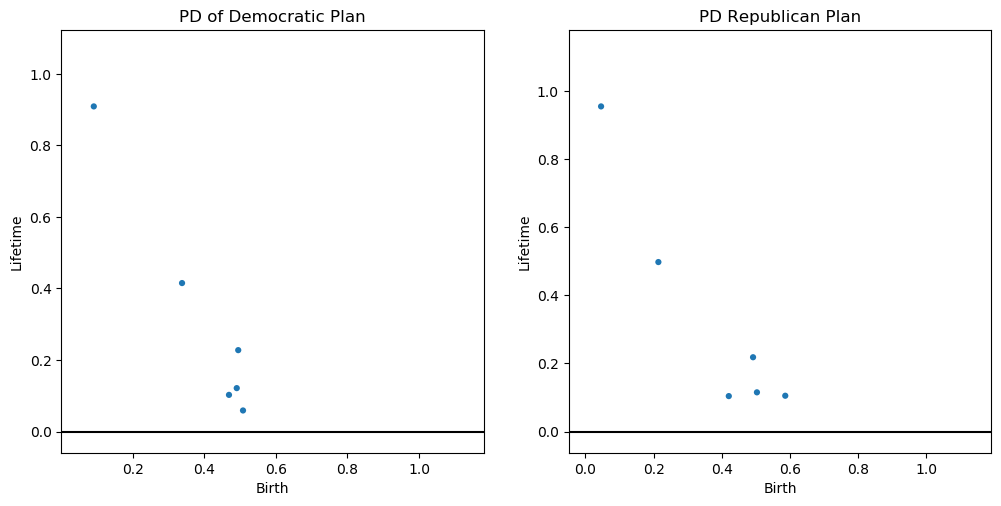

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(121)

random_sample = np.random.randint(50)

rips.plot(all_barcodes[random_sample], show=False, legend=False, lifetime=True)
plt.title("PD of Democratic Plan")

plt.subplot(122)
rips.plot(all_barcodes[-random_sample], show=False, legend=False, lifetime=True)
plt.title("PD Republican Plan")

plt.show()

In [37]:
pim = PersImage(pixels=[30,30], spread=0.01)
imgs = pim.transform(all_barcodes)

PersImage(pixels=[30, 30], spread=0.01, specs=None, kernel_type="gaussian", weighting_type="linear")


We can plot the persistence images as pixelated heat maps.

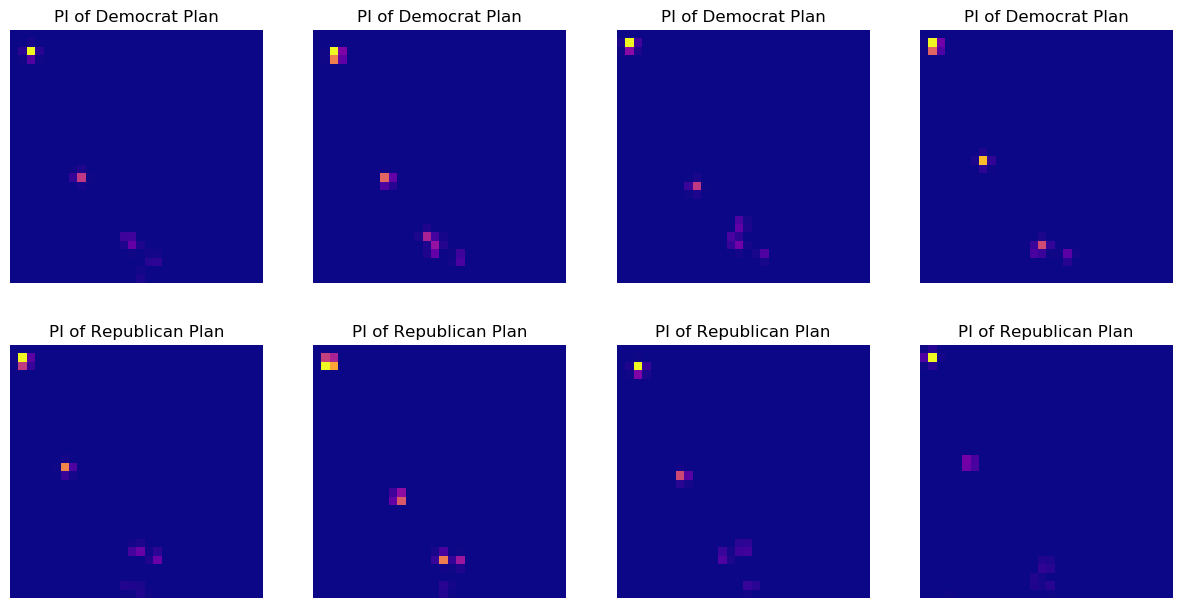

In [38]:
plt.figure(figsize=(15,7.5))

for i in range(4):
    ax = plt.subplot(240+i+1)
    pim.show(imgs[20+i], ax)
    plt.title("PI of Democrat Plan")

for i in range(4):
    ax = plt.subplot(240+i+5)
    pim.show(imgs[-(i+20)], ax)
    plt.title("PI of Republican Plan")

## Classification

As before, we will flatten the images into 1d arrays (vectors).

In [39]:
imgs_array = np.array([img.flatten() for img in imgs])

Create a training and testing set.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array, y, test_size=0.3, random_state=3, stratify = y)
print('Testing set size:',len(y_test))

Testing set size: 129


Now we train and test a SVM model, as before.

In [45]:
modelSVM = SVC(kernel="linear")
modelSVM.fit(X_train, y_train)

modelSVM.score(X_test,y_test)

0.9069767441860465

This is a fairly subtle classification problem, but the TDA signatures seem to do a good job of capturing the differences in these weighted graphs. Changing the `random_state` variable above gives different results, but one can get a more robust statistic by running this over several splits of the data and averaging.

This can be improved with some feature tuning. For example, observe that the most persistent point is pretty much the same across all plans---this is Philadelphia. Removing highly persistent points from all diagrams actually has a positive effect on classification for this example. 

**Unofficial HW:** See if you can improve this classification rate with some tuning.

As above, we can reshape the coefficients of the SVM classification vector to get an idea of how classification works here.

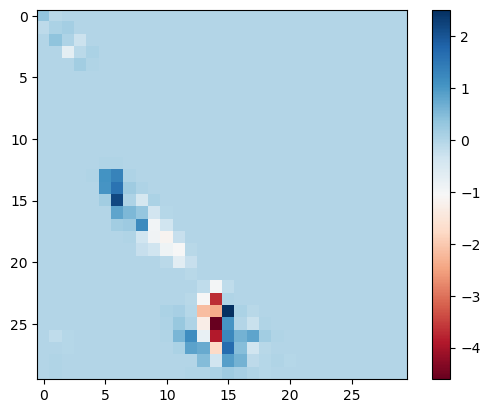

In [46]:
classifying_image = modelSVM.coef_.reshape((30,30))
plt.imshow(classifying_image, cmap = plt.cm.RdBu)
plt.colorbar();